In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import string
import captcha
import editdistance

import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from captcha.image import ImageCaptcha 

# pip install captcha editdistance tensorboard tqdm

corpus : 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, '3HJH')

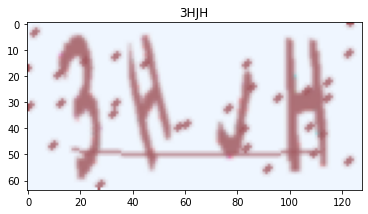

In [2]:
## characters='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters = string.digits + string.ascii_uppercase
print("corpus : {}".format(characters))

## set up size of generated image : width == 128, hright == 64, length == 4
width, height, n_len, n_class = 128, 64, 4, len(characters)

## random generate captcha
generator = ImageCaptcha(width=width, height=height)

## random select character from corpus, lenght == n_len
random_str = ''.join([random.choice(characters) for j in range(n_len)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

### build corpus

In [3]:
n=1 ## keep zero position for "space" class in CTC loss
character_index = {} ## character to index dictionary
index_character = {} ## index to character dictionary
for character in characters:
    character_index[character] = n
    index_character[n] = character
    n += 1

### data loader

[2, 4, 6, 28, 6, 27, 5, 6, 5, 9, 14, 23, 3, 3, 27, 25, 14, 33, 18, 29, 2, 3, 11, 18, 26, 16, 33, 9, 10, 6, 7, 19]
32


character_index: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'J': 20, 'K': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Q': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'X': 34, 'Y': 35, 'Z': 36}
size of character_index: 36


Text(0.5, 1.0, '[2, 4, 6, 28]')

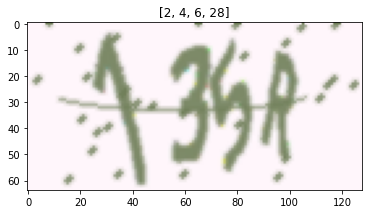

In [4]:
def loader(
    batch_size: int = 8,
    width: int = width,
    height: int = height,
    n_len: int = n_len,
    generator: captcha.image.ImageCaptcha = generator
):
    """ generator : generate batch of captcha
    Args:
        batch_size: batch_size
        width: width of generated images
        height: height of generated images
    Returns:
        Random generated captcha images with corresponding label
    """
    channels = 3 ## RGB
    while True:
        images = np.zeros((batch_size, height, width, channels), dtype=np.uint8)
        labels = []
        for _ in range(batch_size):
            # TODO: generate a captcha image by a random string and save it to "images"
            # TODO: generate a label for this image and save it to "labels"
            # Start coding here

            # End coding here
            images[_] = img
        yield images, labels

data_loader = loader()
images, labels = next(data_loader)

print(labels)
print(len(labels))
print('\n')

print(f"character_index: {character_index}")
print(f"size of character_index: {len(character_index)}")

plt.imshow(images[0])
plt.title(labels[:4])

### model

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dropout_rate):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=dropout_rate)
        )

    def forward(self, x):
        out = self.conv(x)
        return out


class ImageFeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super(ImageFeatureExtractor, self).__init__()
        self.conv1 = resnet_model.conv1
        self.bn1 = resnet_model.bn1
        self.relu = resnet_model.relu
        self.maxpool = resnet_model.maxpool
        self.layer1 = resnet_model.layer1
        self.layer2 = resnet_model.layer2
        self.layer3 = ConvLayer(128, 64, 3, (2, 1), 1, 0.3)
        self.layer4 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
        self.layer5 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
    
# class ImageFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(ImageFeatureExtractor, self).__init__()
#         self.layer1 = ConvLayer(3, 64, 3, (2, 2), 1, 0.3)
#         self.maxpool1 = nn.MaxPool2d(2, 2)
#         self.layer2 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
#         self.maxpool2 = nn.MaxPool2d(2, 2)
#         self.layer3 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
#         self.layer4 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.maxpool1(x)
#         x = self.layer2(x)
#         x = self.maxpool2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         return x
    
class BiRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, drop=0.3):
        super(BiRNN, self).__init__()
        self.GRU = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=False, dropout=drop, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection

    def forward(self, x):
        # TODO: Create forward flow for RNN
        # gru out: tensor of shape (seq_length, batch_size, hidden_size*2)
        return out


class CRNN(nn.Module):
    def __init__(self, cnn_backbone, num_classes=37):
        super(CRNN, self).__init__()
        self.feature_extractor = ImageFeatureExtractor(cnn_backbone)
        self.GRU_First = BiRNN(64, 256, 2, 256, 0.3)
        self.GRU_Second = BiRNN(256, 256, 2, 256, 0.3)
        self.output = torch.nn.Linear(256, num_classes) 

    def forward(self, x):
        # TODO: Create forward flow for CRNN
        # hint: you will need to use "squeeze" and "permute" to transform the tensor from feature_extractor, and then send to GRU
        return x

In [6]:
gru_model = BiRNN(64, 256, 2, 256, 0.3)
output = gru_model(torch.randn(8, 1, 64))
output.shape

torch.Size([8, 1, 256])

In [23]:
model = CRNN(cnn_backbone=models.resnet34(pretrained=True))
output = model(torch.randn(8, 3, 64, 128))
output_step = output.shape[0]
output.shape

torch.Size([16, 8, 37])

### setup for training

In [27]:
batch_size = 64
data_loader = loader(batch_size=batch_size)
ctc_loss = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True) 

# TODO: Build following tensors with correct value and size
# hint: check torch.nn.CTCLoss regarding the definition of those 2 args
input_lengths = torch.tensor([],dtype=torch.long) # output timestep
target_lengths = torch.tensor([],dtype=torch.long) # it can be dynamic, but in our case is fixed
input_lengths = torch.tensor([output_step for _ in range(batch_size)],dtype=torch.long) ## output timestep
target_lengths = torch.tensor([n_len for _ in range(batch_size)],dtype=torch.long) ## it can be 

optimizer = optim.Adam(model.parameters(), lr=0.001 / batch_size)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

model_parameters = filter(lambda p: p.requires_grad, model.train().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total parameters：' ,params)

writer = SummaryWriter(log_dir='crnn_ctc_writer/')

max_iterations = 30 #10000
early_stop = 20
update_period = 10

total parameters： 5417445


### utilities

In [28]:
def decode(prediction, index_character_dictionary=index_character):  ## TODO
    predict_string = ''
    previous_step = 0
    for character in prediction:
        if character > 0 and previous_step != character:
            predict_string += index_character_dictionary.get(character)
        previous_step = character
    return predict_string
    
def get_editdistance_loss(y_true: str, y_pred: str) -> int:
    """Edit distance between two string"""
    return editdistance.distance(y_true, y_pred)

def get_similarity_score(y_true: str, y_pred: str) -> int:
    max_len = max(len(y_pred), len(y_true))
    return (max_len - get_editdistance_loss(y_true, y_pred)) / max_len

### Training loop

In [29]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print('device : {}'.format(device))
model.to(device)
model.train()

device : cpu


CRNN(
  (feature_extractor): ImageFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [30]:
for iteration in tqdm(range(max_iterations)):
    # Ops depends on iteration: modify learning rate, reset recording containers
    if (iteration != 0) and (iteration % update_period == 0):
        lr_scheduler.step()
    if (iteration % update_period == 0):
        average_score_list = []
        average_loss_list = []
    
    # Normalization and permute
    images, labels = next(data_loader)
    images = torch.tensor(images).type(torch.FloatTensor).to(device)
    labels = torch.tensor(labels).type(torch.LongTensor).to(device)
    images = images / 127.5 - 1 
    images = images.permute(0,3,1,2)

    # Reset gradient
    optimizer.zero_grad()

    # Get predition
    output = model(images)
    prediction = output.detach().clone()
    prediction = F.softmax(prediction, 2)
    prediction = prediction.argmax(2).permute(1, 0)
    prediction = prediction.cpu().numpy()
    
    # Calculate loss and backward
    output = torch.nn.functional.log_softmax(output, dim=2)
    loss = ctc_loss(output, labels, input_lengths, target_lengths)
    loss.backward()
    optimizer.step()
    
    # Record metrics
    loss = loss.detach().item()
    average_loss_list.append(loss)
    
    # Decode predictions
    decode_prediction = []
    for item in prediction:
        decode_string = decode(item)
        decode_prediction.append(decode_string)

    # Decode labels
    label_convert = labels.clone().detach().cpu().numpy()
    label_convert = label_convert.reshape(-1, 4)
    decode_label = []
    for item in label_convert:
        decode_string = ''
        for character in item:
            decode_string += index_character.get(character)
        decode_label.append(decode_string)

    # Calculate current socres
    score_list = []
    for predict, ground_truth in zip(decode_prediction, decode_label):
        score = get_similarity_score(ground_truth, predict)
        score_list.append(score)
    average_score = np.mean(score_list)
    average_score_list.append(average_score)

    # Show metrics
    if iteration % update_period == 0:  
        mean_loss_for_100_iteration = np.mean(average_loss_list)
        mean_accuracy_for_100_iteration = np.mean(average_score_list)
        
        writer.add_scalar('train/loss', mean_loss_for_100_iteration, iteration)
        writer.add_scalar('train/score', mean_accuracy_for_100_iteration, iteration)
        
        print('current status : {} iterations'.format(iteration))
        print('current loss： ', mean_loss_for_100_iteration)
        print('accuracy： ', mean_accuracy_for_100_iteration)
        print('\n')

  3%|▎         | 1/30 [00:02<01:04,  2.23s/it]current status : 0 iterations
current loss：  11.585301399230957
accuracy：  0.037779017857142855


 37%|███▋      | 11/30 [00:23<00:40,  2.12s/it]current status : 10 iterations
current loss：  11.453923225402832
accuracy：  0.03796502976190476


 70%|███████   | 21/30 [00:44<00:18,  2.10s/it]current status : 20 iterations
current loss：  11.273883819580078
accuracy：  0.0234375


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


### Save and Load

In [31]:
PATH = './model.pt'
torch.save(model.state_dict(), PATH)

In [32]:
load_model = CRNN(cnn_backbone=models.resnet34(pretrained=True))
load_model.load_state_dict(torch.load(PATH))
load_model.to(device)
load_model.eval()


CRNN(
  (feature_extractor): ImageFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

### Inference

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Prediction: ['']
Ground_Truth: ['RBIX']


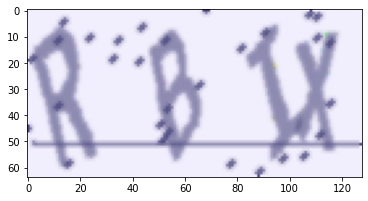

In [35]:
data_loader = loader(batch_size=1)

# Normalization and permute
images, labels = next(data_loader)
plt.imshow(images[0])

images = torch.tensor(images).type(torch.FloatTensor).to(device)
labels = torch.tensor(labels).type(torch.LongTensor).to(device)
images = images / 127.5 - 1 
images = images.permute(0,3,1,2)

# Get predition
output = load_model(images)
prediction = output.detach().clone()
prediction = F.softmax(prediction, 2)
prediction = prediction.argmax(2).permute(1, 0)
prediction = prediction.cpu().numpy()
print(prediction)

# Decode predictions
decode_prediction = []
for item in prediction:
    decode_string = decode(item)
    decode_prediction.append(decode_string)

# Decode labels
label_convert = labels.clone().detach().cpu().numpy()
label_convert = label_convert.reshape(-1, 4)
decode_label = []
for item in label_convert:
    decode_string = ''
    for character in item:
        decode_string += index_character.get(character)
    decode_label.append(decode_string)

print(f'Prediction: {decode_prediction}')
print(f'Ground_Truth: {decode_label}')